<a href="https://colab.research.google.com/github/Joyonclear/ResNet/blob/main/01_Full_Free_Activation_Basic_Block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import time
import numpy as np
!pip install torchinfo
from torchinfo import summary

**~ ResNet 순서별 방식 ~**

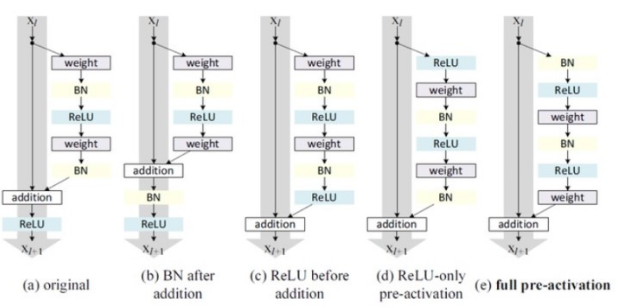

# ResNet Basic Block Design

In [ ]:
# short-cut 기반 네트워크를 사용하기 위해 만드는 sub layer module
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 코드 참고해서 이해하면 좋음

class BasicBlock(nn.Module):
    # expansion = 1 -> bottleneck layer를 사용하지 않겠다.
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # 보통 kernel=7, padding=3 이지만 CIFAR-10은 32*32의 작은 이미지라서 이러면 처음에 손실이 너무 커서 오히려 안좋음
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
    # stride 1 아니거나 입력과 출력이 다르면 shortcut이라는 모델을 하나 만듦
    # kernel=1 -> 동일한 size의 출력으로 convolution 진행 및 정규화
        self.shortcut = nn.Sequential() 
        if stride != 1 or in_planes != self.expansion*planes:  
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False), 
                                            nn.BatchNorm2d(self.expansion*planes)) 

    # Full Free activation 방식의 ResNet inference
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Architecture Design

In [ ]:
# 만들어진 BasicBlock 을 기반으로 network design
# nn.Conv2d의 갯수가 12개가 되도록 하면 됨.(단 shortcut 제외 shortcut의 경우에는 conv layer 개수 셀 때 제외됨.(linear transform으로 취급하는 경우가 많음))
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 코드 참고해서 이해하면 좋음

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ResNet12 Design

In [ ]:
def ResNet12():
    return ResNet(BasicBlock, [1, 2, 1, 1])

net = ResNet12()
input = torch.randn(10, 3, 32, 32)
# torch summary를 통한 conv net, output shape 등에 대한 확인

summary(net, input_size=input.shape)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [10, 32, 32, 32]          864
├─BatchNorm2d: 1-2                       [10, 32, 32, 32]          64
├─Conv2d: 1-3                            [10, 64, 32, 32]          18,432
├─BatchNorm2d: 1-4                       [10, 64, 32, 32]          128
├─Sequential: 1-5                        [10, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [10, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [10, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [10, 64, 32, 32]          128
│    │    └─Conv2d: 3-3                  [10, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-4             [10, 64, 32, 32]          128
│    │    └─Sequential: 3-5              [10, 64, 32, 32]          --
├─Sequential: 1-6                        [10, 128, 16, 16]         --

# DataSet Loading

In [ ]:
#cifar10 의 데이터의 경우 torchvision.datasets 를 사용해 
#데이터를 불러오고 해당하는 데이터를 torch 에서 사용가능하게 dataloader 에 넣어주는 작업을 거칠 예정

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose(
                                [
                                  transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),                                
                                 ]
                               )


# train_data, test_data 를 torchvision에서 제공해주는 datasets.CIFAR10 으로 읽어온다.
# 읽어온 결과는 dataset으로 저장되며 이 dataset은 dataloader를 거쳐서 학습에 사용된다.

train_dataset = datasets.CIFAR10(root = "./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root = "./data", train=False, transform=transform, download=True)

# 데이터의 총 개수 해당 데이터에선 50000개의 데이터가 (img, label)의 tuple 형식으로 저장 되어있다.
print("train_dataset의 개수 : ", len(train_dataset))
print("test_dataset의 개수 : ", len(test_dataset))

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

# data를 배치 단위로 불러오는 법 test
# for 문이 loop를 다 돌면 1 epoch가 끝나는 형태
# tqdm library를 사용해 현재 어느 iteration까지 진행되었는지 notebook 상에서 prograss bar 로 visualize가 가능
for i, (data, target) in enumerate(tqdm(train_loader)):
    if i == 0 :
        print("batch data shape : ", data.shape)
        print("batch data label : ", target)


# Accuracy

In [ ]:
# batch_size의 predict와 label을 받으면 그 결과를 accuracy로 출력한다.
def accuracy(predict, label, printable=False):
  # 해당 연산이 연산의 계산그래프에 들어가면 안되기에 gradient 계산에서 제외한다.
  with torch.no_grad():
    # 각 row마다 predict의 추측값이 가장 높은 값의 index를 가지고 온다.(argmax 사용)
    predicted = torch.argmax(predict.data, 1)
    # 해당하는 predicted 값이 labels와 같은 값인지를 확인한다.
    correct = (predicted == label).sum().item()
    temp_acc = (100 * correct / predict.shape[0])
    if printable:
      print(f'Accuracy of the network on the test images (batch_size : {predict.shape[0]}): {temp_acc}%')
    
    return temp_acc

# Validation

In [ ]:
# validate function
def validate(net, CEloss , test_loader):
  # test data에 따라 검색하기
  start_time = time.time()
  
  total_acc = []
  total_loss = []

  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("device : ", device)
  assert device == "cuda"
  # network를 device type 으로 변경
  net.to(device)

  for data, label in tqdm(test_loader):
    # test data를 돌릴 때에는 gradinet 계산을 하면 안되기에 no_grad로 묶어준다.
    with torch.no_grad():
      # 이 때 data와 label 또한 GPU로 넘겨주어야 한다.
      data = data.to(device)
      label = label.to(device)
          
      # mobilenetv2 모델에 data를 넣어 추측(predict) 한다.
      predict = net(data).to(device)
      
      # 학습 중 batch_size의 accuracy가 보고싶다면 printable=True 를 설정하세요.
      temp_acc = accuracy(predict, label)
      total_acc.append(temp_acc)
      
      # loss의 경우 추측값과 정답값을 비교한다.
      loss = CEloss(predict, label)
      total_loss.append(loss)
      
      # optimizer를 step 하는 것을 통해 optimizer에 선언한 parameter들을 학습시킨다.
  print("\n")
  print(f"Test loss : {np.array(total_loss).sum() / len(total_loss)}")
  print(f"Test accuracy : {np.array(total_acc).sum() / len(total_acc)}")
  print(f"1 epoch time : {time.time() -start_time} (s)")
  print("\n")  


# Train

In [ ]:
# loss 는 내가 네트워크를 어떠한 평가함수로 학습시키고 싶은지에 대한 함수이다.
# classification의 경우 대부분 cross-entropy loss 를 사용한다.
# https://darkpgmr.tistory.com/186 loss에 대한 대략적인 설명
CEloss = nn.CrossEntropyLoss()

# optimizer는 loss.backward() 를 통해 얻은 gradient를 가지고 어떤 방식으로 학습시킬지에 대한 function 이다.
# https://ganghee-lee.tistory.com/24 optimizer에 대한 대략적인 설명
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html  torch.optim.sgd 에 대한 설명
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

def train(net, CEloss, train_loader, optimizer, scheduler, test_loader=False, epochs=20, validate_check=False):
  # GPU를 사용하는지 안 하는지에 대한 확인 만약 CPU로 되어있을 경우 colab runtime 세션관리 에서 GPU 로 변경해두어야 함.
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("device : ", device)
  assert device == "cuda"
  # network를 device type 으로 변경
  net.to(device)

  for epoch in range(epochs):
    total_acc = []
    total_loss = []
    start_time = time.time()
    print(f"{epoch} epcoh start")
    for data, label in tqdm(train_loader):
      # 이 때 data와 label 또한 GPU로 넘겨주어야 한다.
      data = data.to(device)
      label = label.to(device)
      
      # optimizer 에 쓰레기값이 남아있지 않게 zero_grad()를 통해 초기화 시켜준다.
      optimizer.zero_grad()
      
      # resnet12 모델에 data를 넣어 추측(predict) 한다.
      predict = net(data).to(device)
      
      # 학습 중 batch_size의 accuracy가 보고싶다면 printable=True 를 설정하세요.
      temp_acc = accuracy(predict, label)
      total_acc.append(temp_acc)
      
      # loss의 경우 추측값과 정답값을 비교한다.
      loss = CEloss(predict, label)
      total_loss.append(loss)
      
      # loss를 backward 시키는 것을 통해 네트워크의 trainable parameter에 대해 gradient를 구한다.
      loss.backward()
      
      # optimizer를 step 하는 것을 통해 optimizer에 선언한 parameter들을 학습시킨다.
      optimizer.step()
    # scheduler를 통한 lr 감소 확인
    scheduler.step()
    print("\n")
    print(f"lr : {scheduler.get_last_lr()}")
    print(f"{epoch} epcoh loss : {np.array(total_loss).sum() / len(total_loss)}")
    print(f"{epoch} epcoh train accuracy : {np.array(total_acc).sum() / len(total_acc)}")
    print(f"{epoch} epcoh time : {time.time() -start_time} (s)")
    print("\n")
    
    # epcoh 5 마다 valid check
    if epoch % 5 == 0: 
      if validate_check == True and test_loader != False:
        print("===============================")
        print(f"{epoch} epcoh valid")
        validate(net, CEloss, test_loader)
        print("===============================")
    
  # 학습 완료된 후 validation check 
  if validate_check == True and test_loader != False:
      print("===============================")
      print(f"{epochs} epcoh valid")
      validate(net, CEloss, test_loader)
      print("===============================")

# Start

In [ ]:
train(net, CEloss, train_loader, optimizer, scheduler, test_loader, epochs=70, validate_check=True)

## 학습완료 후 네트워크 저장

colab은 원격으로 접근해야 하기에 학습 완료 후 network parameter 저장을 google drive를 통해 저장한다.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
!ls /content/drive/MyDrive/Colab_Notebooks/pruning_result/

### google drive에 네트워크 저장
net 에 저장된 파라미터들을 저장할 예정 net.state_dict() 의 모든 값을 model.pth 로 저장하고 load_state_dict() 로 불러온다.
(자세한 내용은 https://tutorials.pytorch.kr/beginner/saving_loading_models.html 참고)

In [ ]:
# 구글 드라이브 어디에 저장할지에 대해 drive_path 수정
drive_path = "/content/drive/MyDrive/Colab_Notebooks/pruning_result/"
# 만약 구글 드라이브에 저장이 안 되어있을 경우에만 저장
# 저장되어있다면 알아서 model_best.pth 를 파일 이름 변경해서 작업하거나 if 문 지우고 덮어씌어도 됨.
#if os.not.isexists(drive_path+"model_best.pth"):
torch.save(net.state_dict(), drive_path+"model_best.pth")
!ls /content/drive/MyDrive/Colab_Notebooks/pruning_result/

In [ ]:
# 저장된 network 불러오는 방법

# 1. 직접 접근 후 net.load_state_dict(torch.load(file_path)) 로 net 의 parameter 를 저장한 state_dict 에 맞게 다 불러온다.
# 이 때 저장한 파일 구조와 불러올 파일 구조(state_dict)가 다를 경우 error 발생하니 주의 바람.

net.load_state_dict(torch.load(drive_path+"model_best.pth"))

## 참고하면 좋은 Pruning Code

pytorch 공식 pruning tutorial (custom 하기 어려움)
https://tutorials.pytorch.kr/intermediate/pruning_tutorial.html

train after pruning code (unstructured)
https://github.com/ganguli-lab/Synaptic-Flow

gradient median pruning (structured)
https://github.com/he-y/filter-pruning-geometric-median

rethinking-network-pruning (structured)
https://github.com/Eric-mingjie/rethinking-network-pruning